In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import main.packages.mine_generic as mine_g
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

In [2]:
def prepare_X_train_test_pca(X_train, X_test, y, lags, n_components):

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA:
    pca = PCA(n_components = n_components)

    factor_train = pd.DataFrame(pca.fit_transform(X_train_scaled))
    factor_test = pd.DataFrame(pca.transform(X_test_scaled))

    # Create y_lagged:
    y_lagged = pd.DataFrame()
    for lag in range(0, lags + 1):
        y_lagged[f'Lag_{lag}'] = y[y.index <= mine_g.max_X_date].shift(lag)

    # concatenate all:
    X_factor_all = pd.concat([factor_train, factor_test], axis = 0, ignore_index=True)
    factor_col_name = {col: f'factor_{col}' for col in X_factor_all.columns}
    X_factor_all.rename(columns=factor_col_name, inplace=True)

    X_factor_lags_all = pd.concat([y_lagged.reset_index(), X_factor_all], axis=1)
    #X_factor_lags_all.set_index(0, drop=True)
    #X_factor_lags_all.dropna(inplace=True)
    X_factor_lags_all.set_index('date', drop=True, inplace=True)
    print(X_factor_lags_all.shape)
    return X_factor_lags_all

# Recursive forecast
def recursive_forecast_pca(N, T, X_factor_lags_all, y, lags, horizon, verbose = 1):

    predictions = []

    for i in range(T-horizon):

        X_train_pca_temp = X_factor_lags_all.iloc[lags:N+i, :]
        X_test_pca_temp = X_factor_lags_all.iloc[N+i:N+i+1, :]
        y_train_temp = y[lags+horizon:N+i+horizon]

        # Model:
        model = LinearRegression()
        model.fit(X_train_pca_temp, y_train_temp)
        y_pred = model.predict(X_test_pca_temp)
        predictions.append(y_pred[0][0])
        if verbose == 1:
            print(f"Xt train: {X_train_pca_temp.index[0]} - {X_train_pca_temp.index[-1]}")
            print(f"Y(t+h) train: {y_train_temp.index[0]} - {y_train_temp.index[-1]}")
            print(f"X test: {X_test_pca_temp.index}")
            print('---')

    return predictions


In [3]:
# For all categories:
hicp_all_path = 'data/preprocessed/cpi_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'
model = 'prc'

# Food category:

In [4]:
cat_short = 'food'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Food'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Food group:  180


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


## h = 1

In [5]:
horizon = 1
lags = 12
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
(312, 18)


In [6]:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

In [7]:

food_cat_prediction = pd.DataFrame(index=y_test.index)
food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions

## h = 2

In [8]:
horizon = 2
lags = 12
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)


Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
(312, 18)


In [9]:

predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions

## h =3

In [10]:
horizon = 3
lags = 12
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions
food_cat_prediction


Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
(312, 18)


,prc_food_h_1,prc_food_h_2,prc_food_h_3
date,,,
2016-01-31,1.516479,2.246963,2.337054
2016-02-29,0.952438,1.290390,1.958365
2016-03-31,0.960510,0.849770,1.202369
2016-04-30,1.095242,0.736830,0.629217
2016-05-31,1.275819,1.282583,0.975238
...,...,...,...
2022-08-31,11.838994,9.102966,7.644693
2022-09-30,13.289327,12.178509,9.281201
2022-10-31,14.940325,13.680145,12.457030


In [11]:
food_yoy_real = pd.read_csv("data/preprocessed/food_yoy_infl.csv", parse_dates=True, index_col='date')
food_yoy_real_test = food_yoy_real[(food_yoy_real.index > mine_g.train_test_split_date) & (food_yoy_real.index <= mine_g.max_X_date)]
food_compare = pd.concat([food_cat_prediction, food_yoy_real_test], axis = 1)

In [12]:
food_compare

,prc_food_h_1,prc_food_h_2,prc_food_h_3,yoy_rate
date,,,,
2016-01-31,1.516479,2.246963,2.337054,1.209677
2016-02-29,0.952438,1.290390,1.958365,1.103310
2016-03-31,0.960510,0.849770,1.202369,1.402806
2016-04-30,1.095242,0.736830,0.629217,1.195219
2016-05-31,1.275819,1.282583,0.975238,0.896414
...,...,...,...,...
2022-08-31,11.838994,9.102966,7.644693,12.849650
2022-09-30,13.289327,12.178509,9.281201,14.423077
2022-10-31,14.940325,13.680145,12.457030,15.458515


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


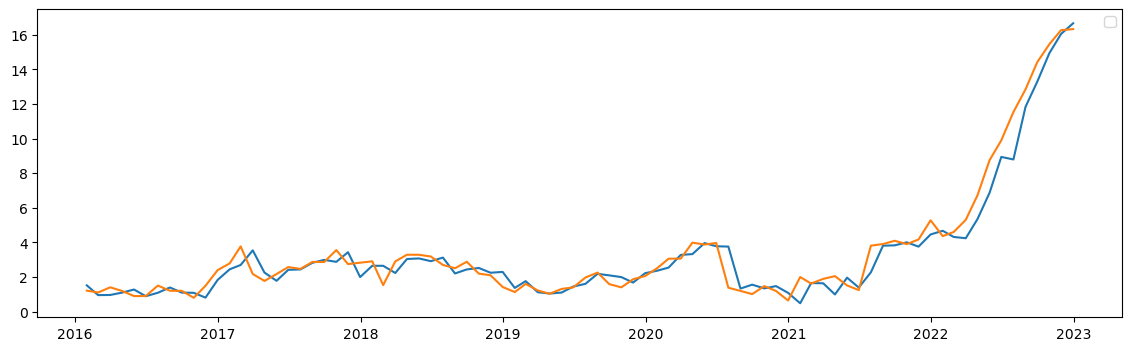

In [13]:
plt.figure(figsize=(14, 4))

plt.plot(food_compare.iloc[:, 0])
plt.plot(food_compare.iloc[:, 3])
plt.legend()
plt.show()

In [14]:
mean_absolute_error(food_compare.loc[:, 'yoy_rate'], food_compare.loc[:, 'prc_food_h_1'])

0.5009483647550693

In [17]:
food_cat_prediction

,prc_food_h_1,prc_food_h_2,prc_food_h_3
date,,,
2016-01-31,1.516479,2.246963,2.337054
2016-02-29,0.952438,1.290390,1.958365
2016-03-31,0.960510,0.849770,1.202369
2016-04-30,1.095242,0.736830,0.629217
2016-05-31,1.275819,1.282583,0.975238
...,...,...,...
2022-08-31,11.838994,9.102966,7.644693
2022-09-30,13.289327,12.178509,9.281201
2022-10-31,14.940325,13.680145,12.457030


In [18]:
# save forecast:
mine_g.save_forecast(forecast_result_df=food_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path)

# Energy:

In [19]:
cat_short = 'energy'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Energy'

save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Energy group:  14


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


## h =1

In [20]:
horizon = 1
lags = 12
n_components = 3

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
energy_cat_prediction = pd.DataFrame(index=y_test.index)
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
(312, 16)


## h = 2

In [21]:
horizon = 2
lags = 12
n_components = 3

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
(312, 16)


In [23]:
horizon = 3
lags = 12
n_components = 3

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
energy_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions
mine_g.save_forecast(forecast_result_df=energy_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path)
energy_cat_prediction

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
(312, 16)


,prc_energy_h_1,prc_energy_h_2,prc_energy_h_3
date,,,
2016-01-31,-4.150957,-3.265409,-5.095043
2016-02-29,-5.284264,-3.636481,-2.915801
2016-03-31,-9.223860,-5.986635,-4.513895
2016-04-30,-8.130491,-8.671201,-5.410966
2016-05-31,-8.989243,-8.679159,-8.868818
...,...,...,...
2022-08-31,35.970997,39.937719,42.842723
2022-09-30,40.159641,39.399301,42.371777
2022-10-31,45.743418,40.834507,38.718992


# Service:

In [24]:
cat_short = 'services'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Services'

save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Services group:  148


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


## h = 1:

In [25]:
horizon = 1
lags = 6
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
services_cat_prediction = pd.DataFrame(index=y_test.index)
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
(312, 12)


## h = 2

In [26]:
horizon = 2
lags = 5
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
(312, 11)


In [28]:
horizon = 3
lags = 4
n_components = 5

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
services_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions
mine_g.save_forecast(forecast_result_df=services_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path)
services_cat_prediction

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
(312, 10)


,prc_services_h_1,prc_services_h_2,prc_services_h_3
date,,,
2016-01-31,1.087786,1.241321,2.189706
2016-02-29,0.717032,0.635946,0.854914
2016-03-31,0.919456,0.818834,0.714219
2016-04-30,0.851811,0.617988,0.543636
2016-05-31,0.881835,1.091343,0.893010
...,...,...,...
2022-08-31,2.147497,2.427213,2.968636
2022-09-30,2.150609,2.274555,2.556510
2022-10-31,3.164126,2.753378,2.801649


# NEGI:

In [29]:
cat_short = 'neig'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Non-energy industrial goods (NEIG)'

save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Non-energy industrial goods (NEIG) group:  302


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [30]:
horizon = 1
lags = 0
n_components = 10

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
neig_cat_prediction = pd.DataFrame(index=y_test.index)
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions

Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00
(312, 11)


In [31]:
horizon = 2
lags = 6
n_components = 10

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions

Horizon: 2
Training predictor period: 1997-01-31 00:00:00 to 2015-10-31 00:00:00
Training dependent variable period: 1997-03-31 00:00:00 to 2015-12-31 00:00:00
(312, 17)


In [32]:
horizon = 3
lags = 6
n_components = 10

X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = cat_df, y = HICP_cat, h = horizon)
N, T = len(X_train), len(X_test)
X_factor_lags_all = prepare_X_train_test_pca(X_train, X_test, HICP_cat, lags, n_components)

# Predict:
predictions = recursive_forecast_pca(N, T, X_factor_lags_all, HICP_cat, lags=lags, horizon=horizon, verbose=0)

# Save forecast:
neig_cat_prediction.loc[:, f'{model}_{cat_short}_h_{horizon}'] = predictions
mine_g.save_forecast(forecast_result_df=neig_cat_prediction.reset_index(drop=True), cat_file_path=save_cat_file_path)
neig_cat_prediction

Horizon: 3
Training predictor period: 1997-01-31 00:00:00 to 2015-09-30 00:00:00
Training dependent variable period: 1997-04-30 00:00:00 to 2015-12-31 00:00:00
(312, 17)


,prc_neig_h_1,prc_neig_h_2,prc_neig_h_3
date,,,
2016-01-31,0.729452,1.159671,1.253438
2016-02-29,1.201077,0.972342,1.229771
2016-03-31,0.983425,1.075789,0.900019
2016-04-30,0.764899,0.928747,1.017031
2016-05-31,1.031533,0.747216,0.858793
...,...,...,...
2022-08-31,5.869285,5.779228,5.249963
2022-09-30,6.148264,6.136310,5.697437
2022-10-31,6.464927,6.239703,6.149065
